# Recurrent Neural Networks (RNNs): From Theory to Practice

## Introduction to Machine Learning - Economics & Management

In this notebook, we'll explore Recurrent Neural Networks (RNNs) through hands-on examples. We'll cover:
1. Understanding RNN architecture and the concept of "memory"
2. Machine Translation using modern frameworks
3. Fun with Text Generation - Creating AI-powered financial news
4. (Bonus) Simple music generation

### Prerequisites
- Basic understanding of neural networks
- No advanced math required - we focus on intuition!

Let's start by setting up our environment:

In [1]:
# Install required packages
!pip install transformers torch datasets matplotlib seaborn numpy pandas -q
!pip install sentencepiece sacremoses -q  # For translation models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Check if GPU is available
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🎉 GPU available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("💻 Using CPU (slower but works!)")

🎉 GPU available: Tesla T4


In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
print("✅ Setup complete!")

✅ Setup complete!


## Part 1: Understanding RNNs - The Power of Memory 🧠

### Why RNNs?
Remember from the lecture: RNNs are designed for **sequential data** where order matters:
- Text (words come in sequence)
- Time series (stock prices over time)
- Music (notes follow each other)

The key innovation: **Memory** - RNNs can remember what they've seen before!

In [7]:
# Let's visualize how RNNs process sequences
# This is a simple demonstration of the "memory" concept

def visualize_rnn_processing(sentence):
    """Simulate how an RNN processes text word by word"""
    words = sentence.split()
    memory_states = []

    print("🔄 RNN Processing Visualization")
    print("=" * 50)

    for i, word in enumerate(words):
        # Simulate memory accumulation
        memory = " ".join(words[:i+1])
        memory_states.append(memory)

        print(f"Step {i+1}:")
        print(f"  Current word: '{word}'")
        print(f"  Memory contains: '{memory}'")
        print(f"  Hidden state encodes: {len(memory)} characters of context")
        print("-" * 50)

    return memory_states

# Example: How RNN processes a financial headline
headline = "Stock prices surge after positive earnings report"
states = visualize_rnn_processing(headline)

print("\n💡 Key Insight: Each step has access to all previous information!")
print("This is why RNNs are perfect for understanding context in sequences.")

🔄 RNN Processing Visualization
Step 1:
  Current word: 'Stock'
  Memory contains: 'Stock'
  Hidden state encodes: 5 characters of context
--------------------------------------------------
Step 2:
  Current word: 'prices'
  Memory contains: 'Stock prices'
  Hidden state encodes: 12 characters of context
--------------------------------------------------
Step 3:
  Current word: 'surge'
  Memory contains: 'Stock prices surge'
  Hidden state encodes: 18 characters of context
--------------------------------------------------
Step 4:
  Current word: 'after'
  Memory contains: 'Stock prices surge after'
  Hidden state encodes: 24 characters of context
--------------------------------------------------
Step 5:
  Current word: 'positive'
  Memory contains: 'Stock prices surge after positive'
  Hidden state encodes: 33 characters of context
--------------------------------------------------
Step 6:
  Current word: 'earnings'
  Memory contains: 'Stock prices surge after positive earnings'
  Hid

## Part 2: Machine Translation - From English to French 🌍

Let's implement machine translation using a modern approach. While transformers have largely replaced RNNs for this task, we'll start with a model that shows the evolution from RNNs.

In [8]:
# Load a translation model (this uses transformer architecture but shows the concept)
print("Loading translation model... (this may take a minute)")

# We'll use a smaller model for faster loading
translator = pipeline("translation_en_to_fr", model="Helsinki-NLP/opus-mt-en-fr")

print("✅ Translation model loaded!")

# Test with some business/economics sentences
test_sentences = [
    "The market showed strong growth this quarter.",
    "Interest rates remain at historic lows.",
    "The company announced record profits.",
    "Inflation concerns are rising globally."
]

print("\n📊 Business English → French Translation Examples:\n")
for sentence in test_sentences:
    translation = translator(sentence)[0]['translation_text']
    print(f"🇬🇧 English: {sentence}")
    print(f"🇫🇷 French:  {translation}")
    print("-" * 60)

Loading translation model... (this may take a minute)


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Device set to use cuda:0


✅ Translation model loaded!

📊 Business English → French Translation Examples:

🇬🇧 English: The market showed strong growth this quarter.
🇫🇷 French:  Le marché a connu une forte croissance ce trimestre.
------------------------------------------------------------
🇬🇧 English: Interest rates remain at historic lows.
🇫🇷 French:  Les taux d'intérêt restent à un niveau historiquement bas.
------------------------------------------------------------
🇬🇧 English: The company announced record profits.
🇫🇷 French:  La société a annoncé des profits records.
------------------------------------------------------------
🇬🇧 English: Inflation concerns are rising globally.
🇫🇷 French:  Les problèmes d'inflation augmentent à l'échelle mondiale.
------------------------------------------------------------


In [9]:
# Interactive translation - try your own sentences!
def interactive_translate():
    print("🌐 Interactive Translator (English → French)")
    print("Type 'quit' to exit\n")

    while True:
        user_input = input("Enter English text: ")
        if user_input.lower() == 'quit':
            break

        translation = translator(user_input)[0]['translation_text']
        print(f"French translation: {translation}\n")

# Uncomment to run interactive mode
# interactive_translate()

# For now, let's translate a business report excerpt
business_text = """
The quarterly earnings report shows promising results.
Revenue increased by 15% compared to last year.
Management remains optimistic about future growth.
"""

print("📈 Translating Business Report:\n")
print("Original English:")
print(business_text)

translated = translator(business_text)[0]['translation_text']
print("\nFrench Translation:")
print(translated)

📈 Translating Business Report:

Original English:

The quarterly earnings report shows promising results.
Revenue increased by 15% compared to last year.
Management remains optimistic about future growth.


French Translation:
Le rapport trimestriel sur les bénéfices montre des résultats prometteurs. Les revenus ont augmenté de 15 % par rapport à l'année dernière. La direction reste optimiste quant à la croissance future.


## Part 3: Text Generation - AI Financial News Writer 📰

Now let's have some fun! We'll create an AI that can generate financial news headlines and short articles. This demonstrates the "one-to-many" RNN architecture from your lecture.

In [10]:
# Load a small GPT-2 model for text generation
print("Loading text generation model...")
model_name = "gpt2"  # Small model that works well on Colab
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)

# Set pad token
tokenizer.pad_token = tokenizer.eos_token

print("✅ Text generation model loaded!")

def generate_financial_news(prompt, max_length=100, temperature=0.8):
    """
    Generate financial news based on a prompt
    - temperature: controls randomness (0.1 = conservative, 1.0 = creative)
    """
    # Tokenize input
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Generate text
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=max_length,
            temperature=temperature,
            num_return_sequences=1,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and return
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Generate some financial news!
prompts = [
    "Breaking: The stock market today",
    "Economic analysts predict that",
    "In a surprising turn of events, Apple's CEO announced",
    "The Federal Reserve decided to"
]

print("\n🤖 AI-Generated Financial News:\n")
for prompt in prompts:
    generated = generate_financial_news(prompt, max_length=80)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated}")
    print("-" * 80)
    print()

Loading text generation model...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Text generation model loaded!

🤖 AI-Generated Financial News:

Prompt: Breaking: The stock market today
Generated: Breaking: The stock market today is in the high teens.

The stock market, according to the Bloomberg New Energy Finance data, has a daily market cap of more than $1 trillion. That's more than the value of the U.S. stock market at $10.8 trillion.

That's a big difference.

In 2015, the Dow Jones Industrial Average closed at
--------------------------------------------------------------------------------

Prompt: Economic analysts predict that
Generated: Economic analysts predict that the U.S. will lose a third of its population by 2050.

"We see a tremendous opportunity for the U.S. economy," said John D. Hodge, senior vice president at the Center for Population and Development Research. "It's a time when the U.S. economy is at its best. It's not a time where we're going
--------------------------------------------------------------------------------

Prompt: In a surpris

In [11]:
# Let's explore how temperature affects generation
prompt = "The cryptocurrency market"
temperatures = [0.3, 0.7, 1.0]

print("🌡️ Effect of Temperature on Text Generation:\n")
print(f"Prompt: '{prompt}'\n")

for temp in temperatures:
    generated = generate_financial_news(prompt, max_length=60, temperature=temp)
    print(f"Temperature {temp} ({'Conservative' if temp < 0.5 else 'Balanced' if temp < 0.8 else 'Creative'}):")
    print(f"{generated}\n")

print("💡 Notice: Lower temperature = more predictable, Higher temperature = more creative!")

🌡️ Effect of Temperature on Text Generation:

Prompt: 'The cryptocurrency market'

Temperature 0.3 (Conservative):
The cryptocurrency market is a highly volatile one, and the price of bitcoin has been volatile for a while now. The price of bitcoin has been volatile for a while now, and it has been a lot of fun to watch.

The following is a list of the top 10 cryptocurrencies in the world

Temperature 0.7 (Balanced):
The cryptocurrency market has seen a steady rise in value in recent years.

As the price of bitcoin has increased, so has its value, according to research firm NPD Group.

The latest report by NPD Group shows that bitcoin has seen an average value increase of 3.9 percent

Temperature 1.0 (Creative):
The cryptocurrency market now has more than 200 million active users. It has received more than $7 billion in venture capital funding and is valued at more than $3 billion. The bitcoin price is at a record high.

The crypto-currency has been heavily criticized in China, where it

## Part 4: Understanding Sequence Processing - Sentiment Analysis 💭

Let's implement a "many-to-one" RNN application: analyzing the sentiment of financial news. This shows how RNNs can process entire sequences and output a single decision.

In [12]:
# Load a sentiment analysis model
print("Loading sentiment analysis model...")
sentiment_analyzer = pipeline("sentiment-analysis",
                            model="ProsusAI/finbert",  # Financial sentiment model!
                            device=0 if torch.cuda.is_available() else -1)
print("✅ Financial sentiment analyzer loaded!")

# Analyze some financial headlines
headlines = [
    "Stock market reaches all-time high amid economic optimism",
    "Company announces massive layoffs and profit warnings",
    "Federal Reserve maintains steady interest rates",
    "Tech stocks plummet as investors flee to safety",
    "Quarterly earnings exceed analyst expectations",
    "Trade tensions escalate between major economies"
]

print("\n📊 Financial Sentiment Analysis:\n")
results = []

for headline in headlines:
    sentiment = sentiment_analyzer(headline)[0]
    results.append({
        'headline': headline,
        'sentiment': sentiment['label'],
        'confidence': sentiment['score']
    })

    # Emoji based on sentiment
    emoji = "📈" if sentiment['label'] == 'positive' else "📉" if sentiment['label'] == 'negative' else "➖"

    print(f"{emoji} {headline}")
    print(f"   Sentiment: {sentiment['label'].upper()} (confidence: {sentiment['score']:.2%})")
    print()

Loading sentiment analysis model...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Financial sentiment analyzer loaded!

📊 Financial Sentiment Analysis:

📈 Stock market reaches all-time high amid economic optimism
   Sentiment: POSITIVE (confidence: 85.62%)

📉 Company announces massive layoffs and profit warnings
   Sentiment: NEGATIVE (confidence: 96.69%)

➖ Federal Reserve maintains steady interest rates
   Sentiment: NEUTRAL (confidence: 83.32%)

📉 Tech stocks plummet as investors flee to safety
   Sentiment: NEGATIVE (confidence: 90.31%)

📈 Quarterly earnings exceed analyst expectations
   Sentiment: POSITIVE (confidence: 91.68%)

📉 Trade tensions escalate between major economies
   Sentiment: NEGATIVE (confidence: 79.49%)



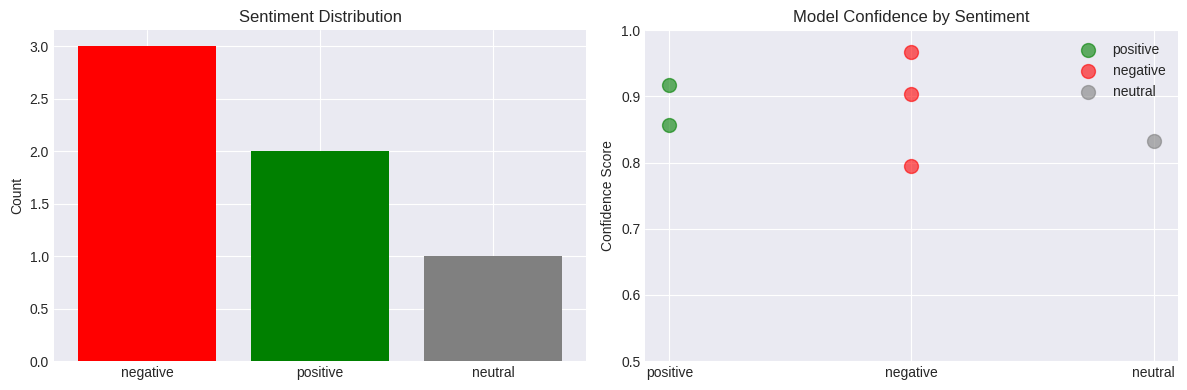


💡 Insight: The model shows high confidence in its predictions!
This demonstrates how RNNs can effectively process entire sequences to make decisions.


In [13]:
# Visualize sentiment distribution
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Sentiment distribution
sentiment_counts = df_results['sentiment'].value_counts()
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
ax1.bar(sentiment_counts.index, sentiment_counts.values,
        color=[colors.get(x, 'blue') for x in sentiment_counts.index])
ax1.set_title('Sentiment Distribution')
ax1.set_ylabel('Count')

# Confidence scores by sentiment
for sentiment in df_results['sentiment'].unique():
    data = df_results[df_results['sentiment'] == sentiment]['confidence']
    ax2.scatter([sentiment] * len(data), data,
               label=sentiment, alpha=0.6, s=100,
               color=colors.get(sentiment, 'blue'))

ax2.set_title('Model Confidence by Sentiment')
ax2.set_ylabel('Confidence Score')
ax2.set_ylim(0.5, 1.0)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n💡 Insight: The model shows high confidence in its predictions!")
print("This demonstrates how RNNs can effectively process entire sequences to make decisions.")

## Part 5: Fun Bonus - Simple Pattern Generation 🎵

While we can't do full music generation in this simple notebook, let's create a pattern generator that demonstrates the concept of sequence generation (like music or time series).

🎼 Sequence Generation (Musical Pattern Simulation)


Pattern: Ascending
Generated: C D E F G A B C D E F G A B C D


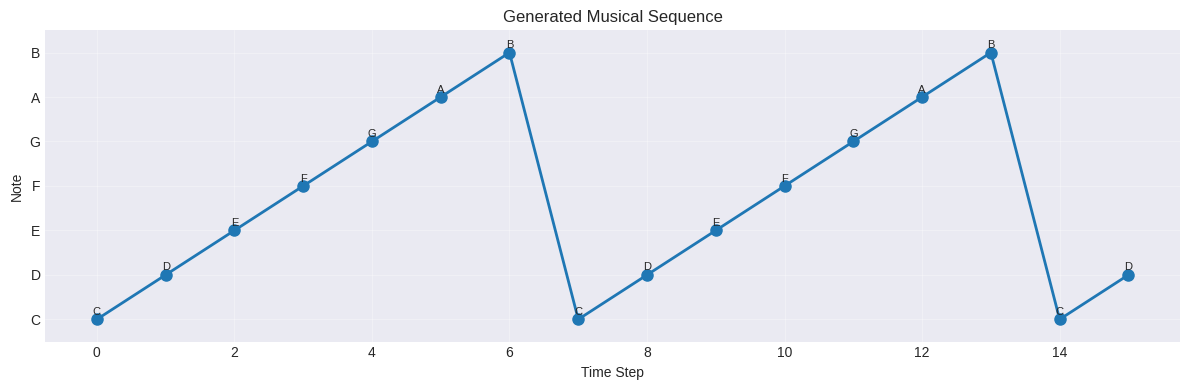


Pattern: Wave
Generated: C E D F E G F C E D F E G F C E


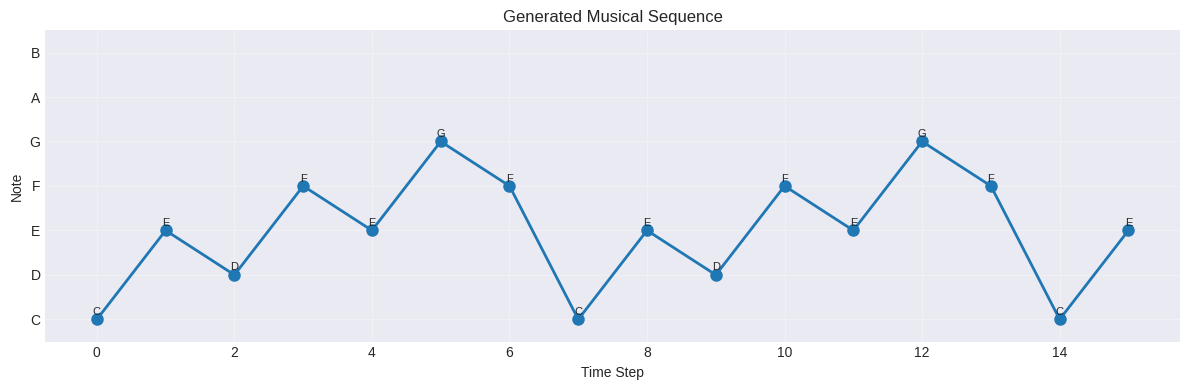


Pattern: Jump
Generated: C E G B D F A C E G B D F A C E


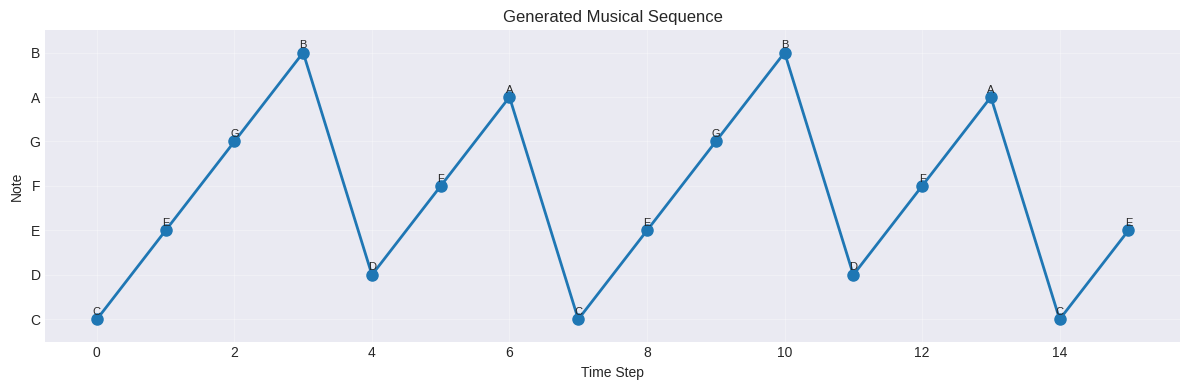


💡 This demonstrates how RNNs can generate sequences with patterns!
Real music generation would use similar principles but with audio data.


In [14]:
# Create a simple sequence generator that mimics musical patterns
class SimpleSequenceGenerator:
    def __init__(self):
        self.notes = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
        self.patterns = {
            'ascending': [0, 1, 2, 3, 4, 5, 6],
            'descending': [6, 5, 4, 3, 2, 1, 0],
            'jump': [0, 2, 4, 6, 1, 3, 5],
            'wave': [0, 2, 1, 3, 2, 4, 3]
        }

    def generate_sequence(self, pattern_name, length=16):
        pattern = self.patterns[pattern_name]
        sequence = []

        for i in range(length):
            note_idx = pattern[i % len(pattern)]
            sequence.append(self.notes[note_idx])

        return sequence

    def visualize_sequence(self, sequence):
        # Convert notes to numbers for plotting
        note_to_num = {note: i for i, note in enumerate(self.notes)}
        numbers = [note_to_num[note] for note in sequence]

        plt.figure(figsize=(12, 4))
        plt.plot(numbers, 'o-', markersize=8, linewidth=2)
        plt.ylim(-0.5, 6.5)
        plt.yticks(range(7), self.notes)
        plt.xlabel('Time Step')
        plt.ylabel('Note')
        plt.title('Generated Musical Sequence')
        plt.grid(True, alpha=0.3)

        # Add note labels
        for i, (num, note) in enumerate(zip(numbers, sequence)):
            plt.text(i, num + 0.1, note, ha='center', fontsize=8)

        plt.tight_layout()
        plt.show()

# Generate and visualize patterns
generator = SimpleSequenceGenerator()

print("🎼 Sequence Generation (Musical Pattern Simulation)\n")

for pattern_name in ['ascending', 'wave', 'jump']:
    print(f"\nPattern: {pattern_name.capitalize()}")
    sequence = generator.generate_sequence(pattern_name, length=16)
    print(f"Generated: {' '.join(sequence)}")
    generator.visualize_sequence(sequence)

print("\n💡 This demonstrates how RNNs can generate sequences with patterns!")
print("Real music generation would use similar principles but with audio data.")

## Part 6: Comparing Architectures - RNN vs Transformer Evolution 🔄

Let's understand why transformers (like BERT and GPT) have largely replaced RNNs for many tasks.

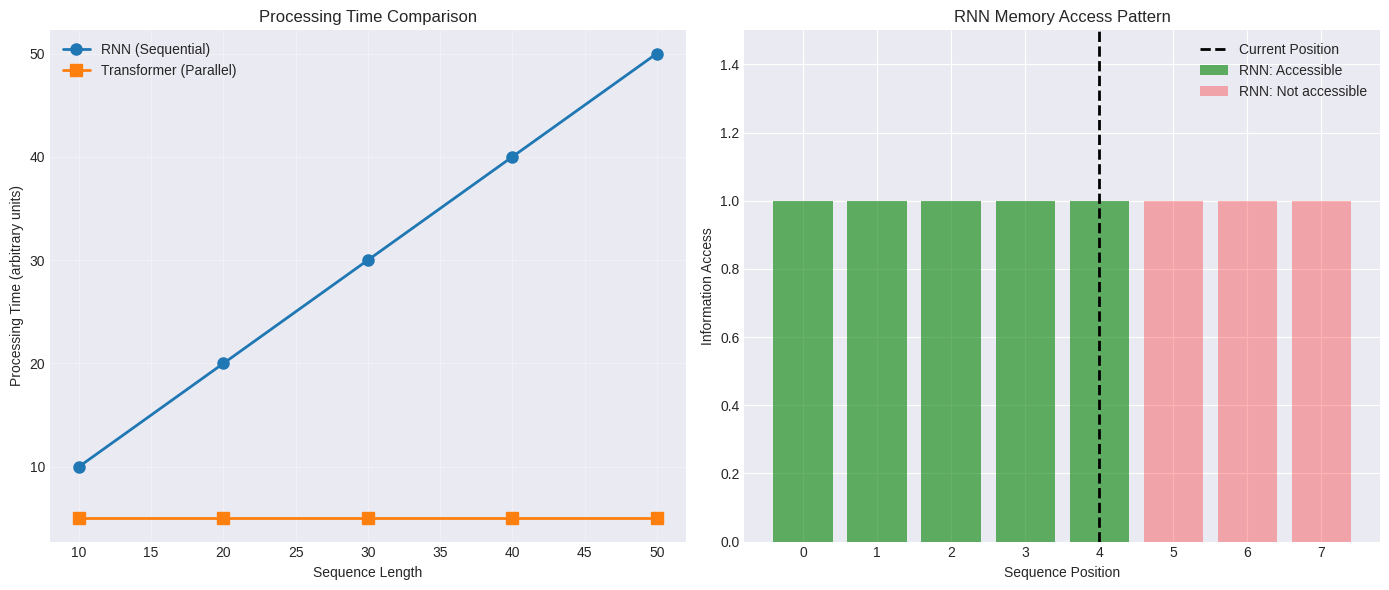


📊 Key Differences:
1. RNNs process sequentially → Slower for long sequences
2. RNNs have limited memory → Forget distant information
3. Transformers process in parallel → Much faster
4. Transformers use attention → Can focus on any part of the input

But RNNs are still useful for:
✓ Real-time processing (one token at a time)
✓ Smaller models with less memory
✓ Simple sequential patterns


In [15]:
# Visualize the key differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# RNN Processing Time (Sequential)
sequence_lengths = [10, 20, 30, 40, 50]
rnn_time = [l for l in sequence_lengths]  # Linear with length
transformer_time = [5] * len(sequence_lengths)  # Constant (parallel)

ax1.plot(sequence_lengths, rnn_time, 'o-', label='RNN (Sequential)', linewidth=2, markersize=8)
ax1.plot(sequence_lengths, transformer_time, 's-', label='Transformer (Parallel)', linewidth=2, markersize=8)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Processing Time (arbitrary units)')
ax1.set_title('Processing Time Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Memory Access Pattern
positions = list(range(8))
current_pos = 4

# RNN: Can only see past
ax2.bar(positions[:current_pos+1], [1]*5, color='green', alpha=0.6, label='RNN: Accessible')
ax2.bar(positions[current_pos+1:], [1]*3, color='red', alpha=0.3, label='RNN: Not accessible')

# Add current position marker
ax2.axvline(x=current_pos, color='black', linestyle='--', linewidth=2, label='Current Position')

ax2.set_xlabel('Sequence Position')
ax2.set_ylabel('Information Access')
ax2.set_title('RNN Memory Access Pattern')
ax2.set_xticks(positions)
ax2.legend()
ax2.set_ylim(0, 1.5)

plt.tight_layout()
plt.show()

print("\n📊 Key Differences:")
print("1. RNNs process sequentially → Slower for long sequences")
print("2. RNNs have limited memory → Forget distant information")
print("3. Transformers process in parallel → Much faster")
print("4. Transformers use attention → Can focus on any part of the input")
print("\nBut RNNs are still useful for:")
print("✓ Real-time processing (one token at a time)")
print("✓ Smaller models with less memory")
print("✓ Simple sequential patterns")

## Summary and Key Takeaways 📝

### What We Learned:

1. **RNN Architecture**: Sequential processing with memory
   - Perfect for ordered data (text, time series, music)
   - Each step remembers previous information

2. **Applications We Explored**:
   - **Many-to-Many**: Machine Translation (English → French)
   - **One-to-Many**: Text Generation (Financial news)
   - **Many-to-One**: Sentiment Analysis (Headlines → Sentiment)

3. **Modern Evolution**:
   - While we used transformer-based models (more modern), they evolved from RNN concepts
   - RNNs laid the groundwork for understanding sequential processing

### Practical Tips for Your Projects:

1. **Start Simple**: Use pre-trained models from HuggingFace
2. **Match Architecture to Task**:
   - Classification? Use many-to-one
   - Generation? Use one-to-many
   - Translation? Use many-to-many
3. **Experiment with Parameters**: Temperature, sequence length, etc.

### Next Steps:
- Try fine-tuning a model on your own data
- Explore LSTM/GRU variants for better long-term memory
- Learn about attention mechanisms and transformers

### Resources:
- HuggingFace Model Hub: https://huggingface.co/models
- PyTorch RNN Tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
- Understanding LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [16]:
# Final interactive demo - Create your own financial report!
print("🎯 Final Challenge: Create an AI Financial Report\n")

def create_financial_report(company_name, industry):
    # Generate different sections
    sections = {
        'headline': f"Breaking news: {company_name} in the {industry} sector",
        'performance': f"{company_name}'s quarterly performance shows",
        'outlook': f"Analysts predict that {company_name}"
    }

    report = f"\n{'='*60}\n"
    report += f"AI-GENERATED FINANCIAL REPORT: {company_name}\n"
    report += f"{'='*60}\n\n"

    for section, prompt in sections.items():
        generated = generate_financial_news(prompt, max_length=80, temperature=0.7)
        report += f"{section.upper()}:\n{generated}\n\n"

    # Add sentiment analysis
    sentiment = sentiment_analyzer(generated)[0]
    emoji = "📈" if sentiment['label'] == 'positive' else "📉" if sentiment['label'] == 'negative' else "➖"

    report += f"SENTIMENT ANALYSIS: {emoji} {sentiment['label'].upper()} ({sentiment['score']:.2%} confidence)\n"
    report += f"{'='*60}\n"

    return report

# Generate a sample report
sample_report = create_financial_report("TechCorp", "technology")
print(sample_report)

print("\n🎉 Congratulations! You've completed the RNN tutorial!")
print("You can now generate text, translate languages, and analyze sentiment.")
print("Try modifying the code to create your own applications!")

🎯 Final Challenge: Create an AI Financial Report


AI-GENERATED FINANCIAL REPORT: TechCorp

HEADLINE:
Breaking news: TechCorp in the technology sector

Tech firms have been trying to move their focus from the cloud to the mobile sector for years. Google has been working on mobile apps and services for years, but it has been a long time since Google has made a big push to mobile. Google has been working on mobile apps and services for years, but it has been a long time since Google

PERFORMANCE:
TechCorp's quarterly performance shows that its financial results are solid. The service giant is continuing to release updates on various segments of the company's business, including its mobile and online video and entertainment division.

Founded in 2005, Cisco Systems (NYSE: CSCO) is a leading provider of secure, secure and secure networking solutions and applications for the home, business, government and business applications

OUTLOOK:
Analysts predict that TechCorp's $1.4 billion acquisit